In [1]:
import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import operator
# import xml.etree.ElementTree as elemTree

#tensor modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from sklearn.metrics import f1_score, accuracy_score

Using TensorFlow backend.


In [31]:
Dict = {'aVF': [], 'aVL': [], 'aVR': [], 'lead I': [], 'lead II': [], 'lead III': [],
           'V1': [], 'V2': [], 'V3': [], 'V4': [], 'V5': [], 'V6': []}
# Dict = {'aVF': []}

for k, v in Dict.items():
    Dict[k] = pd.read_csv(k + '.csv', index_col=0)
for k, v in Dict.items():
    Dict[k] = np.array(v)
Y = pd.read_csv('label.csv', index_col=0)




In [32]:
Dict['aVF'].shape

(173, 660)

In [33]:
X = []
for i in range(Dict['aVF'].shape[0]):
    tmp = []
    for k, v in Dict.items():
        tmp.append(v[i])
    X.append(np.array(tmp).T)
    
X = np.array(X)
print(X.shape)

(173, 660, 12)


In [34]:
types = {'PVC LBBB': 0, 'PVC RBBB': 0, 'sinus': 1}

Y = np.array(Y)
X_data=np.array(X)
Y_data = []

for row in Y:
    for i in row:
        Y_data.append(types[i])
        
Y_data = np.array(Y_data)
print(Y_data)

[0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 1 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1
 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0]


(173, 660, 12) (173,)


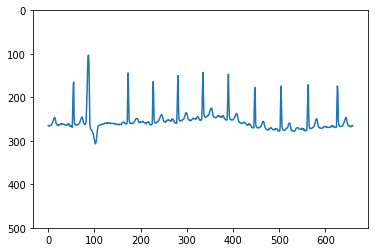

0


In [35]:
print(X_data.shape, Y_data.shape)
# RVOT anteroseptal_ PVC LBBB\08-JUL-2009-09.09.45 PVC LBBB , aVF 이미지
index = [i for i in range(X_data.shape[1])]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_ylim([0, 500])
ax.plot(index, X_data[0].T[0])
plt.gca().invert_yaxis()
plt.show()
print(Y_data[1])


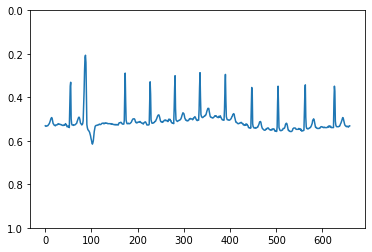

In [36]:
Min = np.min(X_data)
Max = np.max(X_data)

x_data_scale = np.array([[[
    (data-Min)/(Max-Min) for data in steps
    ] for steps in channel
    ] for channel in X_data])



fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_ylim([0, 1])
ax.plot(index, x_data_scale[0].T[0])
plt.gca().invert_yaxis()
plt.show()

In [40]:
y_test = Y_data[0:5]
y_train = Y_data[5:]

x_all = x_data_scale
x_test = x_all[0:5]
x_train = x_all[5:]

print(x_train.shape)
print(y_train.shape)


(168, 660, 12)
(168,)


In [38]:
def get_model():
    nclass = 3
    inp = Input(shape=(660, 12))

    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3_mitbih")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [39]:
model = get_model()
file_path = "baseline_cnn_mitbih.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

model.fit(x_train, y_train, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model.load_weights(file_path)

pred_test = model.predict(x_test)
pred_test = np.argmax(pred_test, axis=-1)

f1 = f1_score(y_test, pred_test, average="macro")

print("Test f1 score : %s "% f1)

acc = accuracy_score(y_test, pred_test)

print("Test accuracy score : %s "% acc)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 660, 12)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 656, 16)           976       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 652, 16)           1296      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 326, 16)           0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 326, 16)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 324, 32)           1568      
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 322, 32)           3104